In [ ]:
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

### load stl-10 dataset

In [ ]:
# load the dataset
transform = torchvision.transforms.ToTensor()

stl = torchvision.datasets.STL10(root='./data', split='train',
                                download=True, transform=transform)
loader = torch.utils.data.DataLoader(stl,
                                     batch_size=128,
                                     shuffle=True,
                                     num_workers=2,
                                     pin_memory=True)


100%|██████████| 2.64G/2.64G [00:32<00:00, 80.3MB/s]


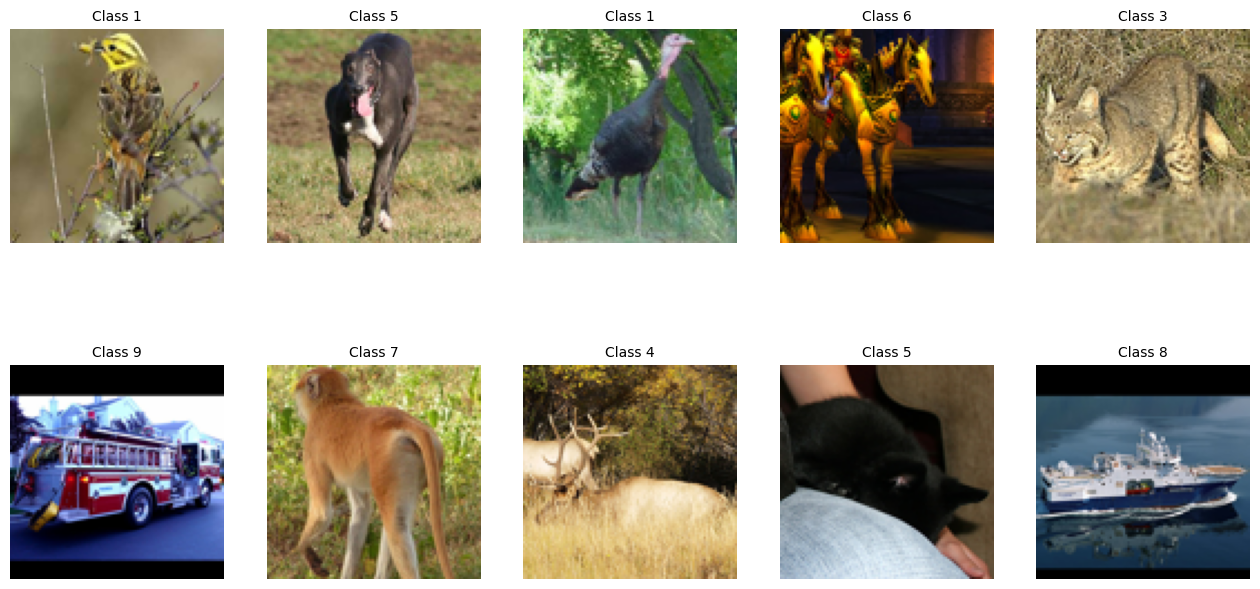

In [ ]:
# show some samples of data
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
for i in range(10):
    image, target = stl[i]
    axes[i // 5, i % 5].imshow(torchvision.transforms.ToPILImage()(image))
    axes[i // 5, i % 5].axis('off')
    axes[i // 5, i % 5].set_title(f"Class {target}", fontsize=10)

plt.show()
plt.close(fig)

### define encoder with covolutional layers

In [ ]:

class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, padding=3) # define convolution layers
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, padding=3)
        self.relu = nn.ReLU() # define RELU activation function
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.lin1 = nn.Linear(128 * 23 * 23, 512)  # Adjust 8*8 to 12*12 based on the network architecture and input image size
        self.lin2 = nn.Linear(512, 256)
        self.mu = nn.Linear(256, latent_dimension) #  predict \mu and \sigma
        self.log_var = nn.Linear(256, latent_dimension)

    def forward(self, inp):
        out = self.conv1(inp)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.reshape(inp.shape[0], -1)
        out = self.lin1(out)
        out = self.relu(out)
        out = self.lin2(out)
        return self.mu(self.relu(out)), self.log_var(self.relu(out))

### define decoder with convolutional layers

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dimension):
        super().__init__()
        self.lin1 = nn.Linear(latent_dimension, 256)
        self.lin2 = nn.Linear(256, 512)
        self.lin3 = nn.Linear(512, 128 * 24 * 24)

        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, z):
        out = self.lin1(z)
        out = nn.functional.relu(out)
        out = self.lin2(out)
        out = nn.functional.relu(out)
        out = self.lin3(out)
        out = out.view(z.size(0), 128, 24, 24)  # reshape to (B, 128, 24, 24)
        out = self.deconv_layers(out)
        return out


### define VAE model which is combination of encoder and decoder

In [ ]:

class Variationaautoencoder(nn.Module):
    def __init__(self, latent_dimension):
        super().__init__()

        self.encoder = Encoder(latent_dimension)
        self.decoder = Decoder(latent_dimension)

    def forward(self, X):
        mu, log_var = self.encoder(X)

        # Reparametrization trick ---> sample z = \mu + \epsilon*\sigma
        std = torch.exp(0.5 * log_var)
        eps = torch.normal(mean=0, std=1, size=std.shape).to(std.device) # generate epsilon
        z = mu + eps*std

        recon_x = self.decoder(z)

        return recon_x, mu, log_var # we need \mu and \sigma to compute loss so return them

In [ ]:
def kl_divergence(mu, log_var):
  kl_loss = -0.5*torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

  return kl_loss

In [ ]:
def reconstruction_loss(recon_x, x):
  recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

  return recon_loss

In [ ]:
def vae_loss(recon_x, x, mu, log_var):

  recon_loss = reconstruction_loss(recon_x, x)
  kl_loss = kl_divergence(mu, log_var)

  loss = recon_loss + kl_loss # vae loss is addition of reconstruction loss and kl divergence

  return loss, recon_loss, kl_loss

# training loop

In [ ]:
# The code runs faster if you run on GPU. Select Runtime -> Change runtime type -> T4 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = Variationaautoencoder(latent_dimension=10).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

number_of_epochs = 300
train_losses = []
kl_losses = []
reconstruction_losses = []

for epoch in range(number_of_epochs):
    model.train()
    total_loss = 0
    total_kl = 0
    total_recon = 0
    for x, _ in loader:
        x = x.to(device)
        optimizer.zero_grad()

        # Compute model predictions
        recontructed_x, mu, log_var = model(x)

        # Compute losses
        loss, recon_loss, kl_loss = vae_loss(recontructed_x, x, mu, log_var)

        # Run backward and optimizer
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    # Compute average loss and store it
    train_losses.append(total_loss / len(loader))
    reconstruction_losses.append(total_recon / len(loader))
    kl_losses.append(total_kl / len(loader))

    print(f'Epoch [{epoch+1}/{number_of_epochs}], Loss: {train_losses[-1]:.4f}')


Epoch [1/300], Loss: 240248.0677
Epoch [2/300], Loss: 210551.7494
Epoch [3/300], Loss: 186604.4773
Epoch [4/300], Loss: 158283.2015
Epoch [5/300], Loss: 146838.0498
Epoch [6/300], Loss: 139744.7090
Epoch [7/300], Loss: 131101.3468
Epoch [8/300], Loss: 124900.5437
Epoch [9/300], Loss: 119906.3484
Epoch [10/300], Loss: 118560.1267
Epoch [11/300], Loss: 116735.2615
Epoch [12/300], Loss: 114152.3999
Epoch [13/300], Loss: 112610.8683
Epoch [14/300], Loss: 111597.9317
Epoch [15/300], Loss: 109549.3773
Epoch [16/300], Loss: 108104.0066
Epoch [17/300], Loss: 108375.5194
Epoch [18/300], Loss: 106423.1551
Epoch [19/300], Loss: 103964.5843
Epoch [20/300], Loss: 102799.8102
Epoch [21/300], Loss: 102556.1136
Epoch [22/300], Loss: 100186.4814
Epoch [23/300], Loss: 97505.7017
Epoch [24/300], Loss: 96398.7459
Epoch [25/300], Loss: 95568.1247
Epoch [26/300], Loss: 94507.4901
Epoch [27/300], Loss: 92920.5438
Epoch [28/300], Loss: 91791.2994
Epoch [29/300], Loss: 93437.1225
Epoch [30/300], Loss: 87729.64

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/VAE_model.pth') # save model in drive to use later


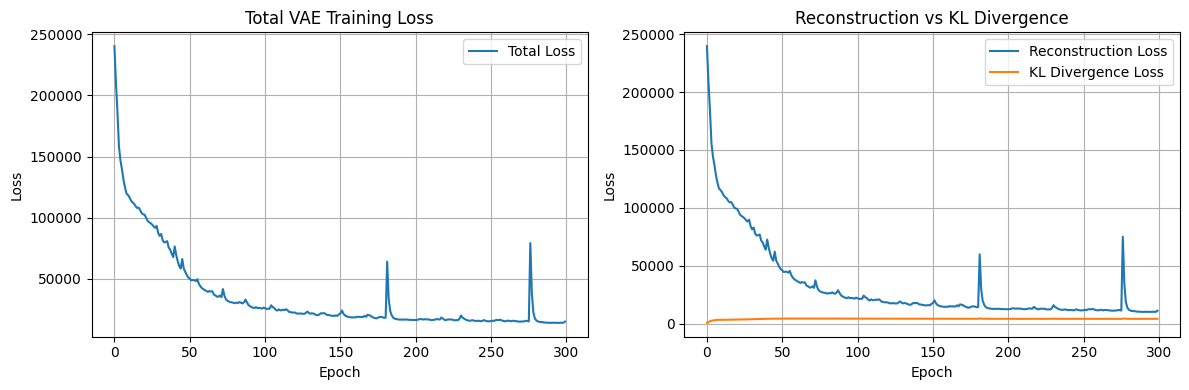

In [ ]:

plt.figure(figsize=(12,4))

# Plot total training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Total Loss')
plt.title('Total VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Plot Reconstruction and KL divergence separately
plt.subplot(1, 2, 2)
plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence Loss')
plt.title('Reconstruction vs KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


above plot shows that model converge after 200 epochs.

### generate samples(they are like Monet paintings)

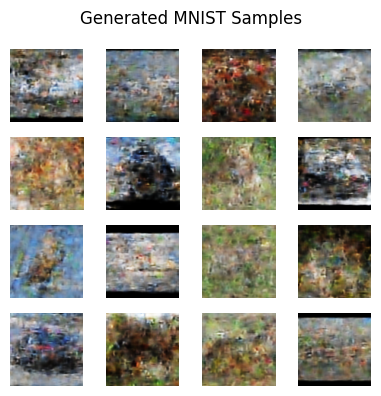

In [ ]:
with torch.no_grad():
    # Generate random latent vectors
    z = torch.randn(16, model.encoder.mu.out_features).to(device)
    samples = model.decoder(z).cpu()

fig, axes = plt.subplots(4,4, figsize=(4,4))
for i, ax in enumerate(axes.flatten()):
    # Permute the dimensions to (height, width, channels)
    image = samples[i].permute(1, 2, 0)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle('Generated MNIST Samples')
plt.tight_layout()
plt.show()